In [1]:
import sys

sys.path.append("../berries")


In [2]:
import random_utils
seed = 0
key_gen = random_utils.infinite_safe_keys(seed)

from datasets import load_dataset
cache_dir="$HOME/.cache/huggingface/datasets"
mnist = load_dataset("mnist", cache_dir=cache_dir, trust_remote_code=True).with_format("jax")
mnistData = mnist['train']

X_img = mnistData['image']
y = mnistData['label']
X_img_test = mnist["test"]["image"]
n_test_samples = X_img_test.shape[0]
y_test = mnist["test"]["label"]
n_samples, _, _  = X_img.shape
X_train = X_img.reshape((n_samples, 1, 28, 28))
X_test = X_img_test.reshape((n_test_samples, 1, 28, 28))
n_channels = 1
d_x = (28, 28)
d_y = len(set(y.tolist()))

In [3]:
n_test_samples = X_test.shape[0]

In [4]:
X = X_train / 255.0
X_test = X_test / 255.0

In [10]:
from jax.numpy import array, exp, mean, sqrt
import nn
import importlib
importlib.reload(nn)
import pf
importlib.reload(pf)
from mixer_mnist import pure_mixer_net, pure_mixer_config
from pf import F, _
import optax

net = pure_mixer_net
net_config = pure_mixer_config

def loss_1(W, x, y):
    return optax.softmax_cross_entropy_with_integer_labels(net(W, x), y)

loss_batch = F(loss_1).vmap((None, 0, 0), 0) >> F(mean)

In [12]:
import optax
from jax import grad, jit
from jax.tree_util import tree_map
from nn import init_weights, fmt_weights
import init_utils



lr = 0.0001
mask_fn = lambda p: tree_map(lambda x: not isinstance(x, int), p)
# opt = optax.multi_transform({"sgd": optax.rmsprop(lr), "zero": optax.set_to_zero()}, mask_fn)
opt = optax.masked(optax.adam(lr), mask_fn)

method = {"type": "zer0", "std": 0.001}
# method = {"type": "normal", "std": 0.01}
# method = {"type": "normal", "std": 0.1}
W0 = init_weights(next(key_gen), net_config(method))
W = W0
print(fmt_weights(W)[0])
loss0 = loss_batch(W, X_test[:100, :], y_test[:100])
print(loss0)
state = opt.init(W)

@jit
def update(W, x, y, opt_state):
    grads = grad(loss_batch)(W, x, y)
    updates, opt_state = opt.update(grads, opt_state)
    new_W = optax.apply_updates(W, updates)
    return new_W, opt_state

head:
    a:
        array shape: (32,)
    0:
        array shape: (32, 3)
    1:
        array shape: (16, 32)
    total params: 640
mix_x:
    in:
        a:
            array shape: (32,)
        0:
            array shape: (32, 2)
        1:
            array shape: (16, 32)
        total params: 608
    out:
        a:
            array shape: (32,)
        0:
            array shape: (32, 2)
        1:
            array shape: (16, 32)
        total params: 608
    total params: 1216
h:
    mglu:
        tuple:
            sglu:
                wv:
                    array shape: (16, 32)
                wu:
                    array shape: (16, 32)
                wo:
                    array shape: (32, 32)
                total params: 2048
            rmsn:
                d:
                    32.0
                total params: 1
            total params: 2049
        tuple:
            sglu:
                wv:
                    array shape: (32, 32)
                w

In [13]:

lr = 0.00001
mask_fn = lambda p: tree_map(lambda x: not isinstance(x, int), p)
# opt = optax.multi_transform({"sgd": optax.rmsprop(lr), "zero": optax.set_to_zero()}, mask_fn)
opt = optax.masked(optax.adam(lr), mask_fn)
state = opt.init(W)


In [14]:
from plot_utils import visualize_matrix
from IPython.display import display
import math, random
import jax.numpy as np


def accuracy(logits, y):
    return (logits.argmax(-1) == y).mean()

def get_accuracy(x, y, W):
    return accuracy(net(W, x), y)

batch_size = 128

train_index = random.sample(range(n_samples), batch_size * 2)
test_index = random.sample(range(n_test_samples), batch_size * 2)

get_accuracy_b = F(get_accuracy).vmap(in_axes=(0, 0, None), out_axes=0)
get_accuracy_b_d = get_accuracy_b.f(X[train_index, :], y[array(train_index)], _) >> mean
# get_accuracy_b_t = get_accuracy_b.f(X_test[test_index, :], y_test[array(test_index)], _) >> mean
# get_accuracy_b_t = get_accuracy_b.f(X_test, y_test, _) >> mean

@jit
def get_accuracy_b_t(W):
    n, val = 0, 0
    for i in range(0, n_test_samples, batch_size):
        real_batch_size = min(n_test_samples - i, batch_size)
        acc_all = get_accuracy_b(X_test[i:i + batch_size, :], y_test[i:i + batch_size], W)
        val +=  mean(acc_all) * real_batch_size
        n += real_batch_size
    return val / n

@jit
def loss_b_dt(W):
    n, val = 0, 0
    for i in range(0, n_test_samples, batch_size):
        real_batch_size = min(n_test_samples - i, batch_size)
        val += mean(loss_batch(W, X_test[i:i + batch_size, :], y_test[i:i + batch_size])) * real_batch_size
        n += real_batch_size
    return val / n



def sample():
    index = random.sample(range(n_samples), batch_size)
    return X[index, :], y[array(index)]

for i in range(30000):
    xx, yy = sample()
    W, state = update(W, xx, yy, state)
    if i % 200 == 0:
        print(mean(get_accuracy_b(xx, yy, W)), get_accuracy_b_t(W), loss_b_dt(W))


print(loss_b_dt(W))


0.046875 0.098 2.3055649
0.1015625 0.1135 2.3019729
0.1015625 0.1135 2.3015273
0.15625 0.1135 2.3012443
0.109375 0.1135 2.3012211
0.1171875 0.098 2.301816
0.0703125 0.1135 2.3011458
0.109375 0.1135 2.3010645
0.1015625 0.1135 2.3010526
0.0703125 0.1135 2.3010085
0.078125 0.1135 2.301067
0.109375 0.1135 2.3010237
0.1328125 0.1135 2.301052
0.1171875 0.1135 2.3010309
0.1171875 0.1135 2.3010266
0.1796875 0.1135 2.3010898
0.09375 0.1135 2.301019
0.046875 0.1135 2.301091
0.09375 0.1135 2.301143
0.1015625 

KeyboardInterrupt: 

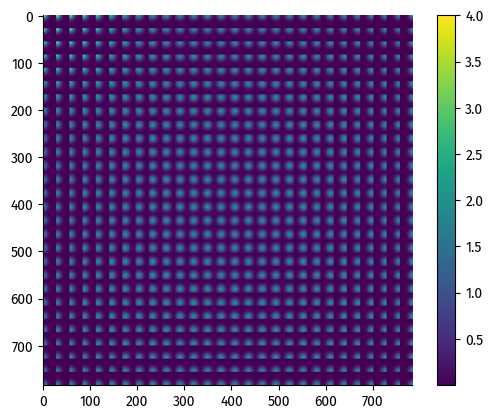

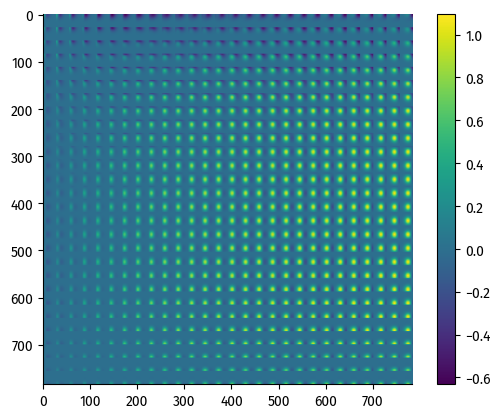

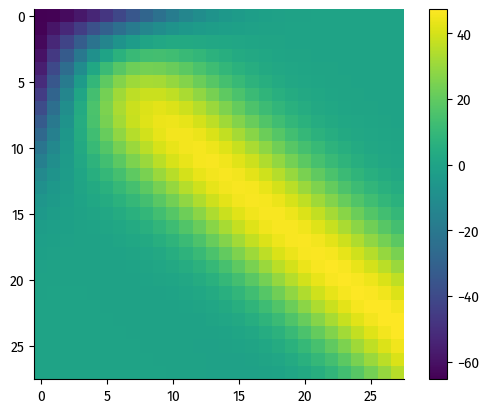

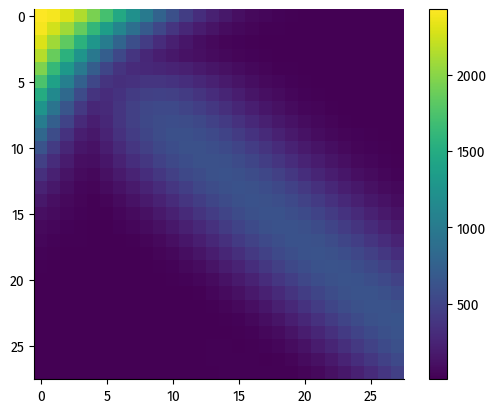

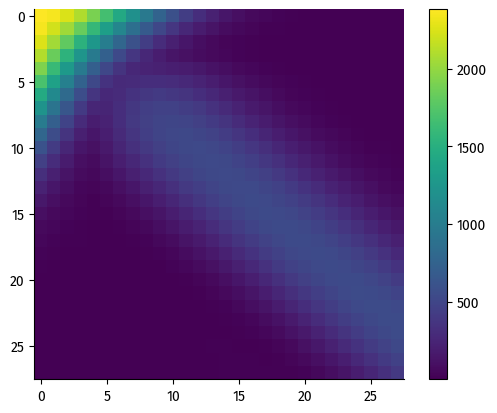

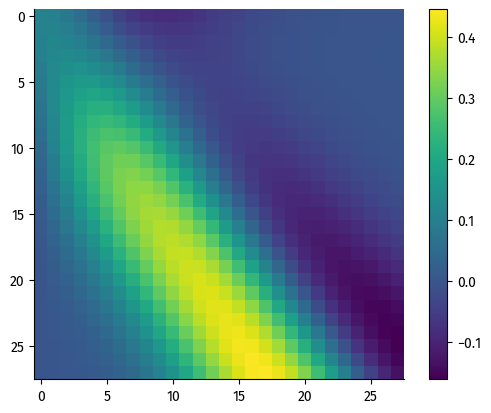

Array([0.9598898, 0.9996202, 0.9598899, 0.9996202, 0.9598898, 0.9996202,
       0.9598898, 0.9996202, 0.9598898, 0.9996202, 0.9598899, 0.9996202,
       0.9598898, 0.9996202, 0.9598899, 0.9996202, 1.0459299, 0.9973904,
       1.0459299, 0.9973904, 1.0459299, 0.9973904, 1.0459299, 0.9973904,
       1.0459299, 0.9973904, 1.0459299, 0.9973904, 1.0459299, 0.9973904,
       1.0459299, 0.9973904], dtype=float32)

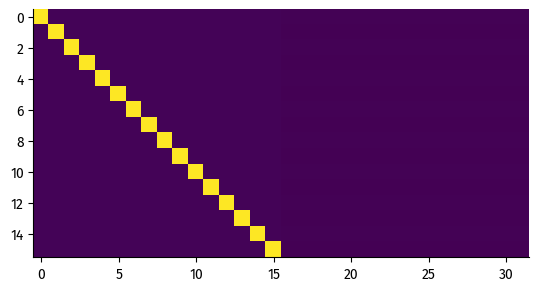

In [148]:

import matplotlib.pyplot as plt
from mixer import mix_x, mixer_head, pure_mixer

plt.imshow(mix_x(W0['mix_x']))
plt.colorbar()
plt.show()
plt.imshow(mix_x(W['mix_x']))
plt.colorbar()
plt.show()
plt.imshow((mix_x(W['mix_x']) @ mixer_head(W['head'], X[4, :])).mean(axis=1).reshape(28, 28))
plt.colorbar()
plt.show()
plt.imshow(pure_mixer(W, X[1, :]).std(axis=1).reshape(28, 28))
plt.colorbar()
plt.show()
plt.imshow(pure_mixer(W, X[0, :]).std(axis=1).reshape(28, 28))
plt.colorbar()
plt.show()
plt.imshow(mix_x(W['mix_x'])[256, :].reshape(28, 28))
plt.colorbar()
plt.show()
plt.imshow(W['mix_x']['in']['1']) 
W['mix_x']['in']['a']
